In [1]:
# This notebook is used for testing.
# Aim: Calculate magnetic fields of different coil configuration

In [ ]:
#Version1:
#Includes formula for calculating the B-field of a straight line from r_start to r_end at any arbitrary position
#Includes formula to calculate B-field of many straight lines; line segments are specified using a tuple_list
#Includes formula to create tuple_list for a single loop

#Version 2:
#Includes function to create tuple list for N loops with same current I

#Version 3:
#Includes cell to plot the coils in 3D

In [47]:
import numpy as np
import scipy.constants
import timeit
import transforms3d #To get rotation matrices
import math
import itertools
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

In [3]:
#Define constants:
mu_0=scipy.constants.mu_0
pi=scipy.constants.pi

In [4]:
#Define some nice functions:
#Function to normalize a vector:
def normalize(a):
    norm = np.linalg.norm(a)
    if norm==0:
        norm = 1
    return a / norm

#Function to get the sign of the angles of two vectors (e_r_01 and e_r_02) with respect to a third one (e_R):
#angles 1 and 2 define the mathematically positive direction
def angle_sign(def_vec1, def_vec2, ref_vec, vec_of_interest):
    x=np.dot(np.cross(def_vec1,def_vec2),np.cross(ref_vec,vec_of_interest))
    if x>0:
        return 1
    else:
        return -1

# Function to create rotation matrix:
def rotation_matrix(axis, theta):
    """
    Return the rotation matrix associated with counterclockwise rotation about
    the given axis (np.array) by theta radians. See Euler–Rodrigues formula (Wikipedia)
    """
    axis = normalize(axis)
    a = np.cos(theta/2.0)
    b, c, d = -axis*np.sin(theta/2.0)
    aa, bb, cc, dd = a*a, b*b, c*c, d*d
    bc, ad, ac, ab, bd, cd = b*c, a*d, a*c, a*b, b*d, c*d
    return np.array([[aa+bb-cc-dd, 2*(bc+ad), 2*(bd-ac)],
                     [2*(bc-ad), aa+cc-bb-dd, 2*(cd+ab)],
                     [2*(bd+ac), 2*(cd-ab), aa+dd-bb-cc]])

#Function to get the rotation angle in a regular polygon:
def theta(N):
    return 2*pi/N


In [5]:
# Function to calculate magnetic field created by a straight piece of wire:
def B_straight_line(r_start,r_end,r_0,I):
    '''r_0 is the point where the B-field is calculated, the wire starts at r_start and ends at r_end, I is the current from r-start to r_end'''
    #Define vectors and corresponding unit vectors:
    r_01=r_start-r_0
    e_r_01=normalize(r_01)
    r_02=r_end-r_0
    e_r_02=normalize(r_02)
    r_wire=r_end-r_start
    e_r_wire=normalize(r_wire)
    #R is the vector from r_0 which is perpendicular to r_wire
    e_R=np.cross(r_wire,np.cross(r_01,r_wire))/(np.linalg.norm(r_wire)*np.linalg.norm(np.cross(r_01,r_wire)))
    R=np.linalg.norm(np.dot(r_01,e_R))*e_R
    #checked: R is perpendicular, R has correct length and is the correct vector
    #print(np.dot(R,r_wire)) #R perpendicular to wire if =0
    #print(np.linalg.norm(R))
    #print(R)
    
    
    #Find angles of r_start and r_end with respect to e_R:
    #Problem: By just taking the vector product or the dot product you get positive angles. So the plan is to use the dot product between e_r_01 and e_r_02 to define a right-handed system. If the dot-product of e_R with e_r_01/e_r_02 is in the same direction, their angle is positive with respect to e_R. -> See Function angle_sign(). 
    alpha_1=angle_sign(e_r_01,e_r_02,e_R,e_r_01)*np.arccos((np.linalg.norm(np.cross(r_start,r_wire)))/(np.linalg.norm(r_start)*np.linalg.norm(r_wire)))
    alpha_2=angle_sign(e_r_01,e_r_02,e_R,e_r_02)*np.arccos((np.linalg.norm(np.cross(r_end,r_wire)))/(np.linalg.norm(r_end)*np.linalg.norm(r_wire)))
    #Check angles:
    #print(alpha_1*360/(2*pi),alpha_2*360/(2*pi))
    
    #Get the unit vector of the B-field
    e_t=np.cross(e_R,e_r_wire)
    #print(e_t)
    
    return mu_0*I/(4*pi*np.linalg.norm(R))*(np.sin(alpha_2)-np.sin(alpha_1))*e_t

In [6]:
#Formula for a circular loop with radius R, B-field measured on axis with distance z to the plane of the loop
def B_circular_loop_onaxis(z,R,I):
    return mu_0*I*R**2/(2*np.power(R**2+z**2,1.5))

In [7]:
#Calculate B-field for snippets of straight wires described by tuples [r_start,r_end]
def B_field(vector_list,r_0,I):
#Map the vector tuples onto the vector arguments of B_straight line (r_start,r_end) and add all resulting B-field vectors together
    return np.sum((map(lambda (r_start,r_end): B_straight_line(r_start,r_end,r_0,I), vector_list)), axis=0)

In [8]:
#Create a function that creates list of vector tuples of one regular polygon loop:
def tuple_list_single_loop(N,r_normal,r_start_side,r_center,r_in):
    '''Function that creates list of vector tuples of a single regular polygon loop.
    Takes arguments:
    N: Number of edges of the polygon
    r_normal: normal vector of the plane of the loop
    r_start_side: vector from the center of the loop to one corner; defines rotational orientation of the loop
    r_center: vector defining the center of the loop
    r_in: variable defining the inner radius of the polygon'''
    #Test that e_start and e_normal are perpendicular
    if 0.0!=np.dot(r_normal,r_start_side):
        print("vectors are not perpendicular!")
    e_normal=normalize(r_normal)
    e_start_side=normalize(r_start_side)
    r_out=r_in/(np.cos(pi/N))
    e_start_corner=np.dot(rotation_matrix(e_normal,theta(N)/2),e_start_side) 
    r_start_corner=r_out*e_start_corner

    #Create list of vector tuples:
    #Use the starting edge vector and rotate it around the symmetry axis by 2pi/N to get the next corner. Every segment goes from one to the next corner.
    tuple_list=[(r_center+np.dot(rotation_matrix(e_normal,i*theta(N)),r_start_corner),r_center+np.dot(rotation_matrix(e_normal,(i+1)*theta(N)),r_start_corner)) for i in range(N)]
    return tuple_list

In [38]:
#Function to create tuple_list for several regular polygon loops with changing parameters r_center,r_in and fixed parameters N,r_normal,r_start_side
def tuple_list_N_loop(N,r_normal,r_start_side,param_list):
    '''Function that creates list of vector tuples of a single regular polygon loop.
    Takes arguments:
    N: Number of edges of the polygon
    r_normal: normal vector of the plane of the loop
    r_start_side: vector from the center of the loop to one corner; defines rotational orientation of the loop
    param_list: parameter list with tuples (r_center,r_in) where
    r_center: vector defining the center of the loop
    r_in: variable defining the inner radius of the polygon'''
    #Create a list of single loop tuple lists 
    list_of_tuple_lists=map(lambda (r_center,r_in):tuple_list_single_loop(N,r_normal,r_start_side,r_center,r_in),param_list)
    #Flatten the list to one big list
    flattend_tuple_list=list(itertools.chain.from_iterable(list_of_tuple_lists))
    return flattend_tuple_list

In [79]:
#Convert tuple_list into np.array with x,y,z where x,y and z are 1D arrays that can be used for 3D plotting
def tuple_list_converter(tuple_list):
    #convert tuple_list to array
    tuple_array=np.array(tuple_list)
    #Check that tuple list has correct form:
    n,t,d=np.shape(tuple_array)
    if (t,d)!=(2,3) or n==0:
        print('Tuple list has not correct shape')
    #print(tuple_array)    
    #print(np.shape(tuple_array))
    #print(tuple_array[0:2,:,:])
    #print(np.shape(tuple_array))
    #rearranged_tuple_array=tuple_array[:,0,:].T
    rearranged_tuple_array=tuple_array.reshape((n*t,d)).T
    #print(np.shape(rearranged_tuple_array))
    #print(rearranged_tuple_array)
    #print(np.shape(rearranged_tuple_array))
    return rearranged_tuple_array

#threeD_array=tuple_list_converter(tuple_list_N_loop(N,r_normal,r_start_side,param_list))
#print(threeD_array)

In [9]:
#Coordinates where we want to calculate the magnetic field:
x_0=0
y_0=0
z_0=0
r_0=np.array([x_0,y_0,z_0])
#print(r_0)
r_start=np.array([1,1,0])
r_end=np.array([-1,1,0])

In [10]:
#Check formula B_straight_line:
# Use a very long wire along the x-axis and get the B-field at arbitrary points in space
#Coordinates where we want to calculate the magnetic field:
x_0=0
y_0=10
z_0=0
r_0=np.array([x_0,y_0,z_0])
#print(r_0)
r_start=np.array([-10000,0,0])
r_end=np.array([10000,0,0])
result=B_straight_line(r_start,r_end,r_0,1)
#print(result)
#print(mu_0*1/(2*pi*10))
#Direction of field and magnitude are correct

#To check the formula, using a square loop with edge length a=0.1m, current I=1A and the B-field is measured at the symmetry axis in the plane of the loop
#Wikipedia, Biot-Savart says for a square loop on the symmetry axis and in the plane of the loop:
def square_loop_wikicheck(a,I):
    return (mu_0*I*2/pi)*np.sqrt(2/(a**2))
#print(square_loop_wikicheck(0.2,1))
#My straight-line-function
x_0=0
y_0=0
z_0=0
r_0=np.array([x_0,y_0,z_0])
square_loop=B_straight_line(np.array([0.1,-0.1,-0.1]),np.array([0.1,0.1,-0.1]),r_0,1)+B_straight_line(np.array([0.1,0.1,-0.1]),np.array([0.1,0.1,0.1]),r_0,1)+B_straight_line(np.array([0.1,0.1,0.1]),np.array([0.1,-0.1,0.1]),r_0,1)+B_straight_line(np.array([0.1,-0.1,0.1]),np.array([0.1,-0.1,-0.1]),r_0,1)
#print(square_loop)
#Test passed

In [29]:
#Compare Circle and regular Polygon
r_normal=np.array([0,0,1])
r_start_side=np.array([1,0,0])
r_center=np.array([0,0,2])
N=4
r_in=1
r_0=np.array([0,0,0])
print(B_field(tuple_list_single_loop(N,r_normal,r_start_side,r_center,r_in),r_0,1)[2])
print(B_circular_loop_onaxis(2,1,1))
print(B_field(tuple_list_single_loop(N,r_normal,r_start_side,r_center,r_in),r_0,1)[2]/B_circular_loop_onaxis(2,1,1))

6.53197264742e-08
5.61985178483e-08
1.16230336627


In [84]:
#Test tuple_list_N_loop(N,r_normal,r_start_side,param_list):

r_normal=np.array([0,0,1])
r_start_side=np.array([1,0,0])
N=4
r_0=np.array([0,0,0])
#Param_list=[(r_center_1,r_in_1),...]
param_list=[(np.array([0,0,1]),1),(np.array([0,0,2]),1)]
#print(tuple_list_N_loop(N,r_normal,r_start_side,param_list))
print(B_field(tuple_list_N_loop(N,r_normal,r_start_side,param_list),r_0,1))

[  3.30872245e-23   2.34783079e-23   2.96259834e-07]


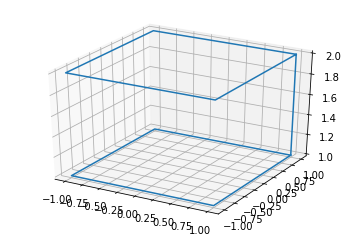

In [87]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
threeD_array=tuple_list_converter(tuple_list_N_loop(N,r_normal,r_start_side,param_list))
#print(threeD_array)
ax.plot(threeD_array[0],threeD_array[1],threeD_array[2],zdir='z')

In [109]:
def B_field_place(x,y,z):
    return B_field(tuple_list_N_loop(N,r_normal,r_start_side,param_list),np.array([x,y,z]),1)
x=np.linspace(1,3,3)
y=np.linspace(-1,0,3)
z=np.linspace(0,0,1)
print(z)
g = np.meshgrid(x, y, z)
positions = np.vstack(map(np.ravel, g))
print(positions.T)
#print(map(B_field_place(x,y,z),positions))
B_field_place(0,0,0)


#im = plt.imshow(Z, cmap=plt.cm.RdBu, extent=(-3, 3, 3, -3))  
#cset = plt.contour(Z, np.arange(-1, 1.5, 0.2), linewidths=2,
#                   cmap=plt.cm.Set2,
#                   extent=(-3, 3, -3, 3))
#plt.clabel(cset, inline=True, fmt='%1.1f', fontsize=10)
#plt.colorbar(im)  

#plt.title('$z=(1-x^2+y^3) e^{-(x^2+y^2)/2}$')

#plt.show()

[ 0.]
[[ 1.  -1.   0. ]
 [ 2.  -1.   0. ]
 [ 3.  -1.   0. ]
 [ 1.  -0.5  0. ]
 [ 2.  -0.5  0. ]
 [ 3.  -0.5  0. ]
 [ 1.   0.   0. ]
 [ 2.   0.   0. ]
 [ 3.   0.   0. ]]


array([  3.30872245e-23,   2.34783079e-23,   2.96259834e-07])